# General Model-New Dataset

In [149]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import os

from tensorflow import keras
from keras.models import load_model
from pycm import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from imblearn.metrics import classification_report_imbalanced
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing

In [2]:
os.getcwd()

'C:\\Users\\marta\\Desktop\\LSE\\Data Science\\Artificial Intelligence\\project-mt2021-ajm\\General model'

In [3]:
# Copy the images of the test benign to the folder train benign.
for i in range(1,1801):
    try:
        path=r"data\test\benign\ "
        source=path.strip() + str(i) + '.jpg'
        destination = r'data\train\benign'
        shutil.copy(source, destination)
    except:
        continue

In [4]:
# Copy the images of the test malignant to the folder train malignant.
for i in range(1,1500):
    try:
        path=r"data\test\malignant\ "
        source=path.strip() + str(i) + '.jpg'
        destination = r'data\train\malignant'
        shutil.copy(source, destination)
    except:
        continue

In [5]:
# Delete the test file
shutil.rmtree(r'data\test')

In [6]:
# Rename the files so that the images have the same class names as the one used to train the model:
os.rename(r'data\train\benign', r'data\train\Benign')
os.rename(r'data\train\malignant', r'data\train\Malignant')

In [7]:
# Rename the train file to test file 
os.rename(r'data\train', r'data\test')

In [106]:
test_path = r'C:\Users\marta\Desktop\LSE\Data Science\Artificial Intelligence\project-mt2021-ajm\General model\data\test'

In [140]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224),batch_size=10,classes=['Benign','Malignant'], shuffle=True)

Found 3297 images belonging to 2 classes.


In [141]:
imgs, labels = next(test_batches)

## Tuned Model

### Running saved model in new data

In [142]:
######################################################### Create function to calculate f1 score to use in model assessment
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [143]:
tuned_model = load_model('GeneralModelnew', custom_objects={'get_f1':get_f1})

In [144]:
tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 64)      

In [145]:
predictions = tuned_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

### Model Assesment

In [135]:
y_true_index=test_batches.classes
y_pred_index=predictions>0.54714
y_pred_index=y_pred_index.astype(int)
y_pred_index=np.concatenate(y_pred_index,axis=0)
classes=['Benign', 'Malignant']

In [146]:
cm = confusion_matrix(y_true=y_true_index, y_pred=y_pred_index)
cm

array([[ 188, 1309],
       [ 233, 1567]], dtype=int64)

In [147]:
cm = ConfusionMatrix(actual_vector=y_true_index,predict_vector=y_pred_index)
print(cm)

Predict    0          1          
Actual
0          188        1309       

1          233        1567       





Overall Statistics : 

95% CI                                                            (0.51527,0.54933)
ACC Macro                                                         0.5323
ARI                                                               -0.00065
AUNP                                                              0.49807
AUNU                                                              0.49807
Bangdiwala B                                                      0.42893
Bennett S                                                         0.0646
CBA                                                               0.33522
CSI                                                               -0.00623
Chi-Squared                                                       0.10932
Chi-Squared DF                                                    1
Conditional Entropy                         

                   pre       rec       spe        f1       geo       iba       sup

     Benign       0.45      0.13      0.87      0.20      0.33      0.10      1497
  Malignant       0.54      0.87      0.13      0.67      0.33      0.12      1800

avg / total       0.50      0.53      0.46      0.45      0.33      0.11      3297



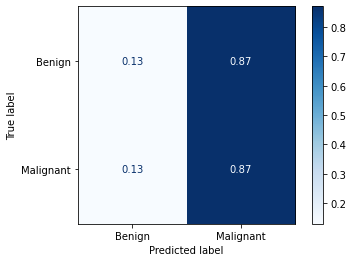

In [148]:
################################################################### Generate a classification report
report = classification_report_imbalanced(y_true_index, y_pred_index, target_names=classes)
print(report)

#################################################################### Generate Confusion matrix
cm = confusion_matrix(y_true_index, y_pred_index,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix = np.round(cm,2), display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

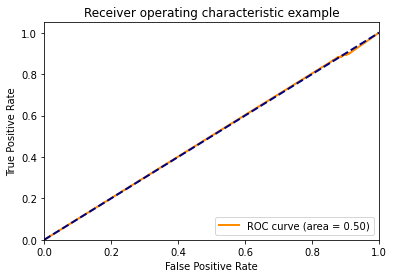

In [153]:
############################################################################## Generate an ROC Curve
fpr, tpr, thresholds = roc_curve(test_batches.classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()